In [1]:
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased")

/Users/alpecevit/Desktop/PythonProjects/Transformers/Sentiment/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv("data/train.csv").rename(columns={"Unnamed: 0": "id", "Label": "labels"})
test = pd.read_csv("data/test.csv").rename(columns={"Unnamed: 0": "id", "Label": "labels"})
test

,id,comment,labels
0,0,arkadaslar film bence cok güzel su anda gidile...,1
1,1,mükemmel bir film ve sonu enfes. mutlaka izley...,1
2,2,epey bi uzak durun diyorum..bu ne ya iyice cil...,0
3,3,"sürükleyici bir aksiyon, özellikle sonu çok sa...",1
4,4,hayatimda izledigim en berbat filmdi gerçekten...,0
...,...,...,...
2661,2661,marvel güzel bir film yapabilirdi ama öyle olm...,0
2662,2662,dünyanin en güzel filmi.baska aciklamasi yok.a...,1
2663,2663,"mutlaka, kesinlikle izlenmesi gereken bir basy...",1
2664,2664,her zaman izlenebilecek bir basyapit. \r\n,1


In [3]:
train = Dataset.from_pandas(train)
test = Dataset.from_pandas(test)
dataset = DatasetDict({"train": train, "validation": test})
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'comment', 'labels'],
        num_rows: 7996
    })
    validation: Dataset({
        features: ['id', 'comment', 'labels'],
        num_rows: 2666
    })
})

In [4]:
id2label = {0: "negative", 1: "positive"}
label2id = {v: k for k, v in id2label.items()}

In [5]:
def preprocess_function(dataframe):
    return tokenizer(dataframe['comment'], truncation=True)

In [6]:
tokenized_dataset = dataset.map(preprocess_function, batched=True,
                                remove_columns=['id',
                                              'comment'])

Map:   0%|          | 0/7996 [00:00<?, ? examples/s]

Map: 100%|██████████| 2666/2666 [00:00<00:00, 21567.46 examples/s]


In [7]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
import evaluate

metrics =  evaluate.combine(["accuracy", "f1", "precision", "recall"])

In [9]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metrics.compute(predictions=predictions, references=labels)

In [10]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [11]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-cased", num_labels=2, id2label=id2label, label2id=label2id
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    collate_fn=data_collator,
    shuffle=True,
    batch_size=16,
)

tf_val_dataset = tokenized_dataset["validation"].to_tf_dataset(
    collate_fn=data_collator,
    shuffle=False,
    batch_size=16,
)

In [13]:
for i in tf_train_dataset.take(1):
    print(i)

{'labels': <tf.Tensor: shape=(16,), dtype=int64, numpy=array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>, 'input_ids': <tf.Tensor: shape=(16, 81), dtype=int64, numpy=
array([[    2,  3550,  3577, ...,     0,     0,     0],
       [    2,  5609,  4686, ...,     0,     0,     0],
       [    2,    94,  1050, ...,     0,     0,     0],
       ...,
       [    2,  2639,  1992, ...,     0,     0,     0],
       [    2,  3951, 13313, ...,     0,     0,     0],
       [    2,    11,  2749, ...,    18,    18,     3]])>, 'token_type_ids': <tf.Tensor: shape=(16, 81), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(16, 81), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 

In [14]:
import tensorflow as tf

model.compile(optimizer=optimizer)  # No loss argument!

In [15]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 110618882 (421.98 MB)
Trainable params: 110618882 (421.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_val_dataset, label_cols=["labels"])

In [17]:
history = model.fit(x=tf_train_dataset, validation_data=tf_val_dataset, epochs=2, callbacks=[metric_callback])

Epoch 1/2
500/500 [==============================] - 1786s 4s/step - loss: 0.2957 - val_loss: 0.1946 - accuracy: 0.9269 - f1: 0.9273 - precision: 0.9221 - recall: 0.9325
Epoch 2/2
500/500 [==============================] - 1754s 4s/step - loss: 0.1436 - val_loss: 0.1902 - accuracy: 0.9359 - f1: 0.9365 - precision: 0.9266 - recall: 0.9467


# Evaluation

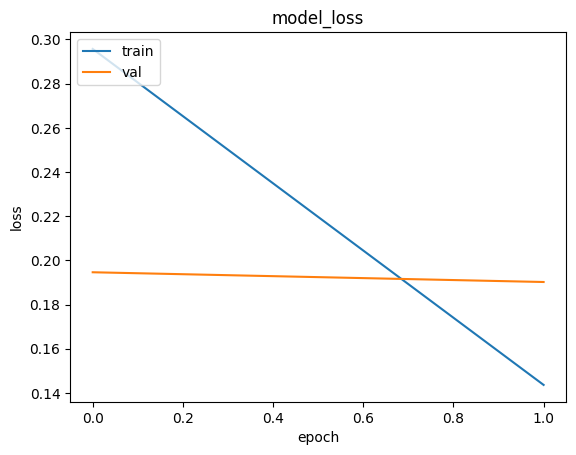

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
all_predictions = []
all_labels = []

In [20]:
for batch in tf_val_dataset:
   logits = model.predict(batch)["logits"]
   labels = batch["labels"].numpy()
   predictions = tf.argmax(logits, axis=-1).numpy()
   # print(labels)
   # print(predictions)
   for prediction, label in zip(predictions, labels):
         all_predictions.append(prediction)
         all_labels.append(label)


1/1 [==============================] - 1s 804ms/step


In [21]:
metrics.compute(predictions=all_predictions, references=all_labels)

{'accuracy': 0.9358589647411854,
 'f1': 0.9365491651205937,
 'precision': 0.9265785609397944,
 'recall': 0.9467366841710427}

# Testing

In [22]:
inputs=tokenizer(["Film güzeldi tekrar izlemek isterim"], truncation=True,return_tensors="tf")

In [23]:
print(inputs.tokens())
print(inputs.word_ids())
print(inputs['input_ids'])

['[CLS]', 'Film', 'güzeldi', 'tekrar', 'izlemek', 'isterim', '[SEP]']
[None, 0, 1, 2, 3, 4, None]
tf.Tensor([[    2  4906 18315  3404  9240  8248     3]], shape=(1, 7), dtype=int32)


In [24]:
logits = model(**inputs).logits
logits.shape

TensorShape([1, 2])

In [25]:
predicted_class = int(tf.math.argmax(logits, axis=-1)[0])
id2label[predicted_class]

'positive'